In [51]:
import sys
sys.path.append('../src')
from constants import fg_year_url

import requests
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Union

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

def get_fg_index_year(
    url: str,
    timeout: int = 10,
    format: str = 'json',
    limit: int = 180
) -> Union[pd.DataFrame, None]:
    """
    Return pd.DataFrame of Fear & Greed index during a year
    """
    url = url.format(format=format, limit=limit)
    try:
        response = requests.get(url, timeout=timeout).json()
        df_list = response['data']
        df = pd.DataFrame(df_list)
        df['timestamp'] = pd.to_numeric(df['timestamp'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.date

        df = df.rename(columns={'value': 'fg_index_num',
                                'value_classification': 'fg_index_str',
                                'timestamp': 'index_date'
                                })
        df = df[['fg_index_num', 'fg_index_str', 'index_date']]
        return df
    except requests.exceptions.RequestException as e:
        logger.error("Error getting Fear & Greed data: %s", e)
        return None

In [52]:
figure = get_fg_index_year(fg_year_url)
figure

,fg_index_num,fg_index_str,index_date
0,24,Extreme Fear,2025-10-12
1,27,Fear,2025-10-11
2,64,Greed,2025-10-10
3,70,Greed,2025-10-09
4,60,Greed,2025-10-08
...,...,...,...
175,37,Fear,2025-04-20
176,32,Fear,2025-04-19
177,33,Fear,2025-04-18
178,30,Fear,2025-04-17


In [65]:
def scatter_index(df):
    category_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
    colors = ['green', 'blue', 'gray', 'orange', 'red']
    df['month'] = pd.to_datetime(df['index_date'])
    df['month_key'] = df['month'].dt.to_period('M')
    monthly_average = df.groupby(['month_key', 'fg_index_str']).size().unstack(fill_value=0)
    monthly_average = monthly_average[category_order]
    plt.figure(figsize=(12, 8))
    ax = monthly_average.plot(kind='bar', stacked=False, color=colors, width=0.8, ax=plt.gca())
    labels=[period.strftime('%b %Y') for period in monthly_average.index]
    ax.set_xticklabels(labels)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel('Number of days', fontsize=12)
    plt.title("Fear & Greed Index distribution by month", fontsize=14, fontweight='bold')
    plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

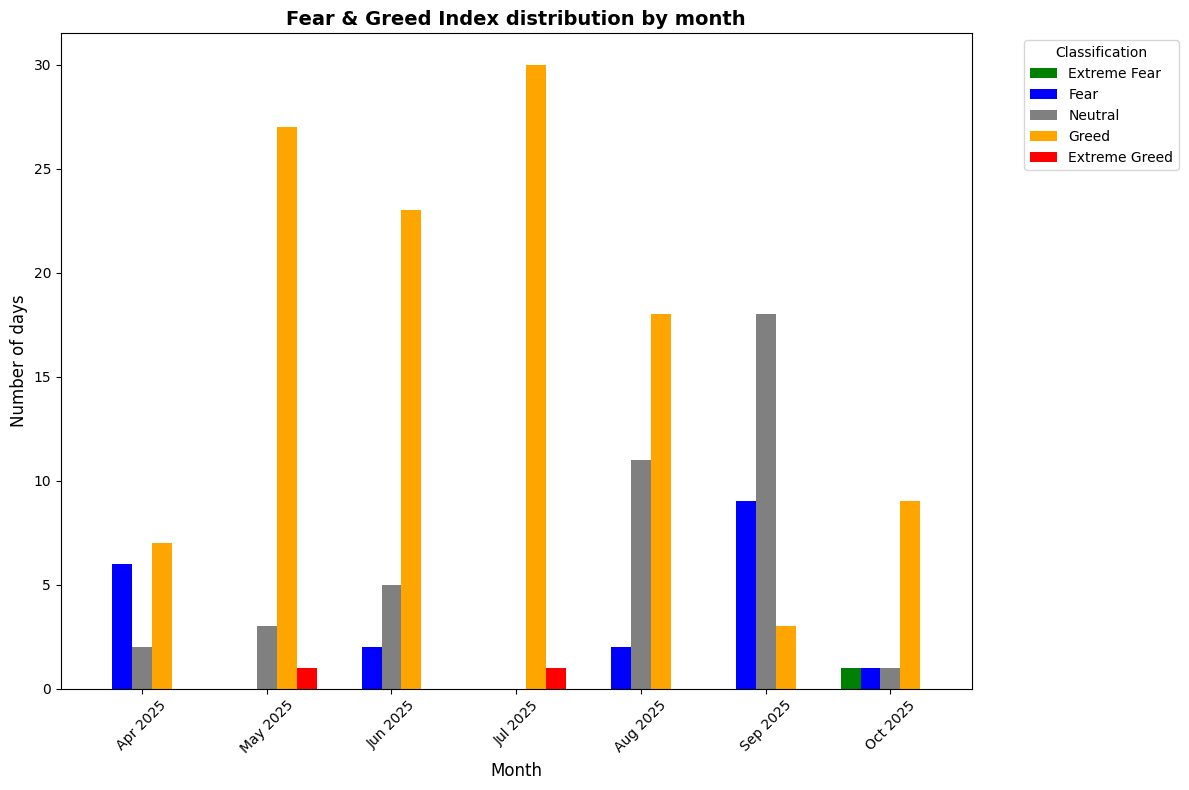

In [66]:
res = scatter_index(figure)